<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/deep-learning-from-scratch-2/Chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ゲート付きRNN
+ 単純なRNNでは時系列データの長期の依存関係をうまく学習することはできない。

## RNNの問題点
+ BPTTにおいて勾配消失もしくは勾配爆発問題が起こることに原因がある。
 + ようは、長い時点をさかのぼっての、誤差逆伝播法がうまくいかないということ。

### RNNの復習
+ RNNレイヤは時系列データである\\(x_t\\)を入力すると\\( h_t\\)を出力する。この\\( h_t\\)はRNNレイヤの隠れ状態とも呼ばれ、過去からの情報が記憶される。
+ RNNレイヤの順伝播で行う計算は、「行列の積と和、そして活性化関数であるtanh関数による変換」から構成される。

### 勾配消失もしくは勾配爆発
+ RNNレイヤが過去方向に「意味のある勾配」を伝達することによって、時間方向の依存関係を学習することができる。
 + この勾配が途中で弱まったら、ほとんど何も情報をもたなくなったら、重みのパラメータは更新されなくなる。

### 勾配消失もしくは勾配爆発の原因
+ 逆伝播において勾配がtanhノードを通るたびに、その値はどんどん小さくなっていく。
 + tanh関数をT回通過すれば、勾配はT回も繰り返し弱められることになる。
   + ReLUを使えば勾配消失を抑えることができる。
    + 入力xが0異常であれば、逆伝播では上流の勾配をそのまま下流に流すことになり、勾配の劣化が起こらないから。 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # バッチサイズ
H = 3 # 隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H)) # 初期化
np.random.seed(3) # 再現性のため乱数のシードを固定
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T) # 更新
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)


In [2]:
norm_list

[2.4684068094579303,
 3.335704974161037,
 4.783279375373183,
 6.2795873320876145,
 8.080776465019055,
 10.25116303229294,
 12.9360635066099,
 16.276861327786712,
 20.454829618345983,
 25.688972842084684,
 32.25315718048336,
 40.48895641683869,
 50.824407307019094,
 63.79612654485427,
 80.07737014308985,
 100.51298922051251,
 126.16331847536827,
 158.3592064825883,
 198.77107967611957,
 249.495615421267]

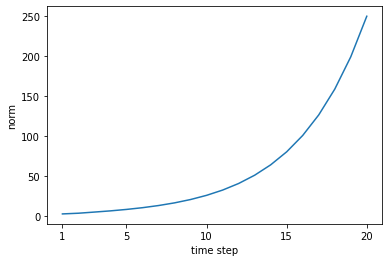

In [3]:
# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配の大きさは時間とともに指数関数的に増加していく。

In [0]:
dh = np.ones((N, H)) # 初期化
np.random.seed(3) # 再現性のため乱数のシードを固定
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T) # 更新
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)


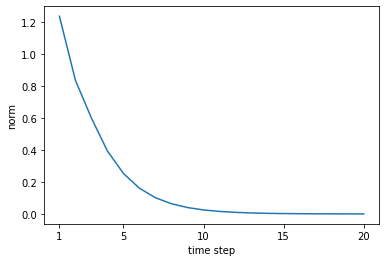

In [5]:
# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

今度は勾配が指数的に減少している。

行列\\( Wh\\)をT回繰り返して乗算しているので、指数的な変化が起きてしまう。

### 勾配爆発への対策
+ 勾配クリッピング
 + 勾配のL2ノルムが閾値を超えた場合に勾配を修正する。

$$ if \ \| \hat g \| \ \geq threshold \\
\hat g = \frac{threshold}{\| \hat g \|}\hat g $$

In [0]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad ** 2)
  total_norm = np.sqrt(total_norm)

  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate

clip_grads(grads, max_norm)

## 勾配消失とLSTM
+ RNNの学習の際に問題となる、勾配消失問題を解消したい。

### LSTMのインタフェース
+ LSTMにはRNNにはない、記憶セルというものがある。
+ LSTMの出力を受け取る側から見ると、LSTMの出力は隠れ状態ベクトルのhだけになり、記憶セルcの情報は外部には見えない。

### LSTMレイヤの組み立て
+ 現在の記憶セル\\( c_t\\)は3つの入力（\\( c_{t-1}, h_{t-1}, x_{t}\\)）から何らかの計算によって求めることができる。
+ 更新された\\( c_t\\)を使って、隠れ状態の\\( h_t\\)が計算される。
+ LSTMで使用するゲートは、開く・閉じるの二択ではなく、どれだけゲートを開くか、そしてそれによって、どのくらいの量の水を次へ流すかということをコントロールする。それに関してもデータから自動的に学ばせる。

### outputゲート
+ \\(  \tanh (c_t) \\)の各要素に対して、それらが次時刻の隠れ状態としてどれだけ重要かということを調整し、\\( h_t \\)をコントロールする。
+ outputゲートの開き具合は\\( x_t\\)と前の状態\\( h_{t-1}\\)から求める。

$$ o = \sigma ( x_t W^{(o)}_x + h_{t-1}W_h^{(o)} + b^{(o)}) $$

出力はアダマール積で計算
$$ h_t = o \odot \tanh (c_t) $$


### forgetゲート
+ 記憶セルに対して、何を忘れるかを明示的に指示すること。
+ \\( c_{t-1}\\)の記憶から、不要な記憶を忘れるためのゲートを追加する。

$$ f = \sigma (x_t W_x^{(f)} + h_{t-1}W_{h}^{(f)} + b^{(f)} ) $$


出力はアダマール積で計算
$$c_t = f \odot c_{t-1}$$

### 新しい記憶セル
+ 新しく覚えるべき情報を記憶セルに追加する。
 + tanhノードを新たに追加する。


$$g = \tanh (x_t W_x^{(g)} + h_{t-1}W_h^{(g)} + b^{(g)})$$

新しい情報を記憶セルに追加することが目的のため、活性化関数にsigmoidではなく、tanh関数を使う。0-1でなくてもいいということ。

gが\\( c_{t-1}\\)に加算されることで、新しい記憶が生まれる。

### inputゲート
+ gの各要素が新たに追加する情報として、どれだけの価値があるかを判断する。追加する情報の取捨選択を行う。

$$ i = \sigma ( x_t W_x^{(i)} + h_{t-1} W_h^{(i)} + b^{(i)} ) $$

出力はアダマール積で計算
$$ g \odot i $$

### LSTMの勾配の流れ
+ LSTMの逆伝播では、行列の積の計算ではなく、要素ごとの積が計算される。
 + 毎時刻、異なるゲート値によって要素ごとの積の計算が行われる。その結果、勾配消失が起きない。
 + 忘れるべきと判断した記憶セルの要素に対しては、その勾配の要素は小さくなる。
 + 忘れてはいけないと導いた要素に対しては、その勾配の要素は劣化することなく過去方向へ伝わる。 

## LSTMの実装

$$ f = \sigma ( x_t W_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)} ) \\
g = \tanh(x_tW_x^{(g)} + h_{t-1}W_h^{(g)} +b^{(g)}) \\
i = \sigma(x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)}) \\
o = \sigma(x_tW_x^{(o)} + h_{t-1}W_h^{(o)} + b^{(o)}) \\
\\
c_t = f \odot c_{t-1}+ g \odot i \\
h_t = o \odot \tanh(c_t) $$


+ ここに出てくる4つの重みに関してまとめて処理する。
+ 行列ライブラリは大きな行列としてまとめて計算したほうが多くの場合、計算が高速化される。

In [0]:
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b] # パラメータ
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配
    self.cache = None # 順伝播での中間結果を保持

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    # アフィン変換：平行移動を伴う線型写像
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    # 4つ分の重みをまとめて保持するので、スライスする必要がある。
    # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    # シグモイドやらハイパボリックタンジェントをかます
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    # 上の式にある通り
    c_next = f*c_prev + g*i
    h_next = o*np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next


### TimeLSTMの実装
+ T個分の時系列データをまとめて処理するレイヤ

In [0]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful # 状態を維持するかどうかを指定

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    # 初期化
    hs = np.empty((N, T, H), dtype='f')

    # 隠れ状態hと記憶セルcの初期化
    if not self.stateful or self.h is None:
      self.h = np.zeros_like((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros_like((N, H), dtype='f')

    # 時点の数だけ繰り返す
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)

    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]
    # 逆の時点から繰り返す
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grads

    self.dh = dh
    return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

## LSTMを使った言語モデル

In [9]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 378 (delta 0), reused 0 (delta 0), pack-reused 373
Receiving objects: 100% (378/378), 7.91 MiB | 11.21 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [10]:
cd deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [11]:
ls

ch01/  ch03/  ch05/  ch07/  common/   LICENSE.md
ch02/  ch04/  ch06/  ch08/  dataset/  README.md


In [0]:
import sys
sys.path.append('..')

from common.time_layers import *
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100,
               hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 重みの初期化
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # レイヤの生成
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    # すべての重みと勾配をリストにまとめる
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

  # パラメータの書き込み
  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)

  # パラメータの読み込み
  def load_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

Done
Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 7[s] | perplexity 2965.95
| epoch 1 |  iter 41 / 1327 | time 13[s] | perplexity 1247.29
| epoch 1 |  iter 61 / 1327 | time 20[s] | perplexity 969.02
| epoch 1 |  iter 81 / 1327 | time 27[s] | perplexity 783.35
| epoch 1 |  iter 101 / 1327 | time 34[s] | perplexity 653.61
| epoch 1 |  iter 121 / 1327 | time 41[s] | perplexity 641.88
| epoch 1 |  iter 141 / 1327 | time 47[s] | perplexity 600.89
| epoch 1 |  iter 161 / 1327 | time 54[s] | perplexity 579.60
| epoch 1 |  iter 181 / 1327 | time 61[s] | perplexity 579.73
| epoch 1 |  iter 201 / 1327 | time 68[s] | perplexity 502.86
| epoch 1 |  iter 221 / 1327 | time 75[s] | perplexity 502.25
| epoch 1 |  iter 241 / 1327 | time 82[s] | perplexity 456.13
| epoch 1 |  iter 261 / 1327 | time 88[s] | perplexity 470.11
| epoch 1 |  iter 281 / 1327 | time 95[s] | perplexity 461.30
| epoch 1 |  iter 301 / 1327 | time 102[s] | perplexity 392.89
| 

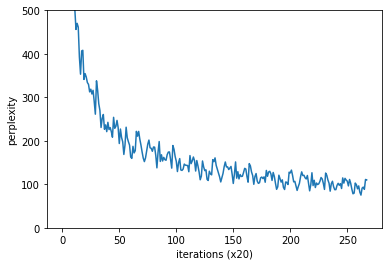

evaluating perplexity ...
234 / 235
test perplexity:  136.3136962392949


In [14]:
import sys
sys.path.append('..')

from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 35 # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# STEP1:勾配クリッピングを適用して学習
# モデルの勾配を求め、モデルのパラメータを更新する
# max_gradで勾配の爆発を防ぐ
# eval_intervalでパープレキシティを計算するイタレーションの単位を決める
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
# パープレキシティに関して可視化
trainer.plot(ylim=(0, 500))

# STEP2:テストデータで評価
# モデルの状態をリセットしてからテストデータでのパープレキシティを評価する
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# STEP3:パラメータの保存
model.save_params()

最新の研究ではパープレキシティは60を下回っているらしい。

## RNNLMのさらなる改善
+ LSTMレイヤの多層化
+ Dropoutによる過学習の抑制
+ 重み共有

### LSTMレイヤの多層化
+ LSTMレイヤを何層も重ねることで、より複雑なパターンを学習できるようにする。
+ 重なる層の数は、それがハイパーパラメータとなる。データやタスクによって適宜決める必要がある。

### Dropoutによる過学習の抑制
+ RNNはフィードフォワード型のネットワークよりも簡単に過学習をしてしまう。
  + RNNにおいて過学習対策は研究が活発になされているらしい。

+ 過学習を避けるための方法
 + 訓練データを増やす
 + モデルの複雑さを減らす
 + 正則化を行う
 + Dropoutのように訓練時にレイヤ内のニューロンのいくつかをランダムに無視して学習を行う 


+ Dropoutをどこに挟むべきか？
 + LSTMレイヤの時系列方向？変分Dropoutという手法があり、それならば有効だが、そのまま入れてもうまくいかない。
 + LSTMレイヤ自体の深さに関してDropoutを挟むのは有効。

### 重み共有
+ 例えば、Embeddingレイヤの重みとAffineレイヤの重みを結びつけるテクニック
 + 2つのレイヤで重みを共有することで、学習するパラメータを大きく減らすことができる。

### より良いRNNLMの実装

In [0]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650,
               hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H) / np.aqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H) / np.aqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 3つの改善！
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeDropout(dropout_ratio), # Dropout層を縦に追加している！
                   TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True), # LSTMレイヤを重ねている！
                   TimeDropout(dropout_ratio),
                   TimeAffine(embed_W.T, affine_b) # 重み共有！
    ]

    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
    self.params, self.grads = [], []

    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs, train_flg=False):
    for layer in self.drop_layers:
      layer.train_flg = train_flg

    for layer in self.layers:
      xs = layer.forward(xs)
    return loss

  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()


In [0]:
import sys
sys.path.append('..')
from common import config
config.GPU = True

from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
  trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
              time_size=time_size, max_grad=max_grad)
  model.reset_state()
  ppl = eval_perplexity(model, corpus_val)
  print('valid perplexity: ', ppl)

  if best_ppl > ppl:
    best_ppl = ppl
    model.save_params()

  else:
    lr /= 4.0
    optimizer.lr = lr 

  model.reset_state()
  print('-'*50)

Done
Done
Done
| epoch 1 |  iter 1 / 1327 | time 3[s] | perplexity 9999.99
| epoch 1 |  iter 21 / 1327 | time 63[s] | perplexity 3443.83
| epoch 1 |  iter 41 / 1327 | time 125[s] | perplexity 1709.85
| epoch 1 |  iter 61 / 1327 | time 185[s] | perplexity 1288.33


GPUでも学習に5時間かかるらしい。